Analyzing parquet file: data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet
Parquet file has 4 row groups and approximately 466,957 rows
Processing 4 row groups


Processing row groups:   0%|          | 0/4 [00:00<?, ?it/s]

Row group 0: 123,235 rows, processing in 3 chunks


Chunks in row group 0:   0%|          | 0/3 [00:00<?, ?it/s]

Row group 1: 123,717 rows, processing in 3 chunks


Chunks in row group 1:   0%|          | 0/3 [00:00<?, ?it/s]

Row group 2: 123,096 rows, processing in 3 chunks


Chunks in row group 2:   0%|          | 0/3 [00:00<?, ?it/s]

Row group 3: 96,909 rows, processing in 2 chunks


Chunks in row group 3:   0%|          | 0/2 [00:00<?, ?it/s]

Analysis complete. Calculated 466,957 valid weighted means from 466,957 total rows


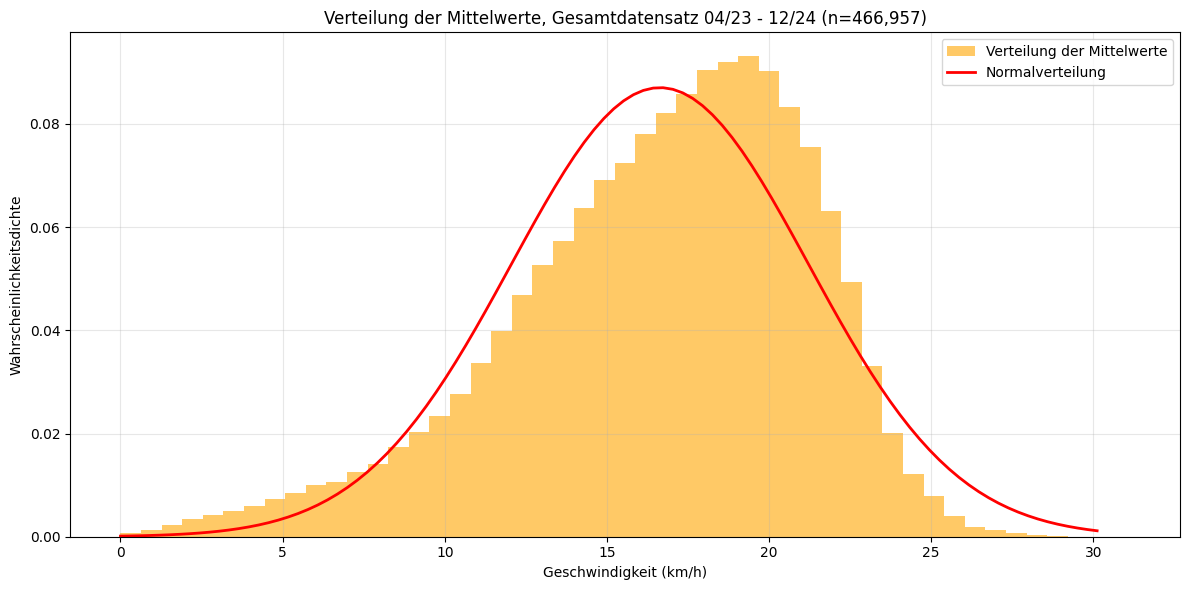

Längengewichtete Analyse abgeschlossen. Überprüfen Sie das Ausgabeverzeichnis für Ergebnisse.


In [7]:
# Visueller Test auf Normalverteilung (gesamter Datensatz)
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pyarrow.parquet as pq
import gc
from tqdm.notebook import tqdm

# Configuration - modify to match your setup
PARQUET_FILE = "data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet"
OUTPUT_DIR = "analysis_results/CLT_test"
COLUMN_HIST = '2304-2412_speeds'  # Column for speed histogram data
COLUMN_LENGTH = 'length_m'  # Column for length in meters

# Make sure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def log(message):
    """Print a timestamped log message"""
    print(message)

def force_gc():
    """Force garbage collection"""
    gc.collect()

def parse_histogram(hist_str):
    """Parse histogram string to numpy array"""
    try:
        if isinstance(hist_str, str):
            hist_str = hist_str.strip('[]')
            # Fast NumPy parsing
            try:
                values = np.fromstring(hist_str, sep=',')
                return values
            except:
                # Fallback to manual parsing if NumPy method fails
                values = [float(x) for x in hist_str.split(',')]
                return np.array(values)
        else:
            return np.zeros(32)  # Return zeros for missing histograms
    except Exception as e:
        log(f"Error parsing histogram: {e}")
        return np.zeros(32)

def calculate_weighted_mean(histogram):
    """Calculate weighted mean from a histogram"""
    speed_bins = np.arange(32)  # 0-31 km/h
    total_count = np.sum(histogram)
    
    if total_count > 0:
        mean_speed = np.sum(speed_bins * histogram) / total_count
        return mean_speed
    return np.nan

def verify_central_limit_theorem():
    """Verify the central limit theorem for OSM speed data using the full dataset with length-weighting"""
    log(f"Analyzing parquet file: {PARQUET_FILE}")
    
    # Verify the parquet file exists
    if not os.path.exists(PARQUET_FILE):
        log(f"Error: File {PARQUET_FILE} not found")
        return None, None, None
    
    # Get file info to understand what we're working with
    parquet_file = pq.ParquetFile(PARQUET_FILE)
    num_row_groups = parquet_file.metadata.num_row_groups
    total_rows = parquet_file.metadata.num_rows
    log(f"Parquet file has {num_row_groups} row groups and approximately {total_rows:,} rows")
    
    # Define the specific columns we need
    columns = [COLUMN_HIST, COLUMN_LENGTH]
    
    # Initialize storage for results
    segment_means = []
    segment_weights = []
    total_rows_processed = 0
    
    # Process each row group with efficient chunking
    log(f"Processing {num_row_groups} row groups")
    
    # Define chunk size for efficient processing within each row group
    CHUNK_SIZE = 50000
    
    for rg in tqdm(range(num_row_groups), desc="Processing row groups"):
        try:
            # Get the row group size to determine number of chunks needed
            row_group_metadata = parquet_file.metadata.row_group(rg)
            row_group_size = row_group_metadata.num_rows
            num_chunks = (row_group_size + CHUNK_SIZE - 1) // CHUNK_SIZE  # Ceiling division
            
            log(f"Row group {rg}: {row_group_size:,} rows, processing in {num_chunks} chunks")
            
            # Read the entire row group
            table = parquet_file.read_row_group(rg, columns=columns)
            
            # Process each chunk of the row group
            for chunk_idx in tqdm(range(num_chunks), desc=f"Chunks in row group {rg}", leave=False):
                # Calculate offsets
                offset = chunk_idx * CHUNK_SIZE
                length = min(CHUNK_SIZE, row_group_size - offset)
                
                # Extract just this chunk from the row group
                chunk_table = table.slice(offset, length)
                df_chunk = chunk_table.to_pandas()
                
                # Filter out NaN values
                df_chunk = df_chunk.dropna(subset=[COLUMN_HIST, COLUMN_LENGTH])
                
                # Process each row in this chunk
                for _, row in df_chunk.iterrows():
                    hist = parse_histogram(row[COLUMN_HIST])
                    if len(hist) > 0 and np.sum(hist) > 0:
                        mean = calculate_weighted_mean(hist)
                        if not np.isnan(mean):
                            segment_means.append(mean)
                            segment_weights.append(row[COLUMN_LENGTH])
                
                # Update progress counter
                total_rows_processed += len(df_chunk)
                
                # Clean up to free memory after each chunk
                del df_chunk, chunk_table
                force_gc()
            
            # Clean up the entire row group data
            del table
            force_gc()
                
        except Exception as e:
            log(f"Error processing row group {rg}: {e}")
    
    log(f"Analysis complete. Calculated {len(segment_means):,} valid weighted means from {total_rows_processed:,} total rows")
    
    # Convert to numpy arrays for analysis
    segment_means = np.array(segment_means)
    segment_weights = np.array(segment_weights)
    
    # Check if we have enough data to proceed
    if len(segment_means) < 30:
        log("Warning: Not enough data points for reliable CLT verification")
        return segment_means, segment_weights, None, None
    
    # Calculate total weight for reporting only
    total_weight = np.sum(segment_weights)
    
    # No logging of mean values
    
    # Create figure with single histogram plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot 1: Length-weighted histogram
    bins = np.linspace(max(0, np.min(segment_means) - 1), np.max(segment_means) + 1, 50)
    
    # Use weights in the histogram
    hist_values, bin_edges, _ = ax1.hist(
        segment_means, 
        bins=bins, 
        weights=segment_weights,  # Use weights for the histogram
        density=True, 
        alpha=0.6, 
        color='orange', 
        label='Verteilung der Mittelwerte'
    )
    
    # Generate x values for normal distribution curve
    x = np.linspace(min(segment_means), max(segment_means), 100)
    
    # Calculate normal PDF with weighted mean and std
    normal_pdf = stats.norm.pdf(x, weighted_mean, weighted_std)
    
    # Plot the normal distribution curve
    ax1.plot(x, normal_pdf, 'r-', linewidth=2, label='Normalverteilung')
    
    # No normal distribution overlay
    
    ax1.set_title(f'Verteilung der Mittelwerte, Gesamtdatensatz 04/23 - 12/24 (n={len(segment_means):,})')
    ax1.set_xlabel('Geschwindigkeit (km/h)')
    ax1.set_ylabel('Wahrscheinlichkeitsdichte')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # No need to remove QQ Plot as it's not created
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(OUTPUT_DIR, 'laengengewichtete_geschwindigkeitsverteilung.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # No calculation of weighted skewness and kurtosis
    
    # No normality tests
    
    # Create and save summary to a text file
    summary = f"""Längengewichtete Datenanalyse Zusammenfassung
=========================================
Verarbeitete Zeilen insgesamt: {total_rows_processed:,}
Gültige Segmente: {len(segment_means):,}
Gesamtstreckenlänge: {total_weight/1000:.2f} km

Hinweis: Diese Analyse basiert auf Geschwindigkeitsverteilungen, die aus Histogrammen berechnet wurden, wobei jedes Segment entsprechend seiner Länge gewichtet wurde.
Es wurden alle verfügbaren Daten ohne Stichprobennahme verwendet.
    """
    
    with open(os.path.join(OUTPUT_DIR, 'laengengewichtete_analyse_zusammenfassung.txt'), 'w') as f:
        f.write(summary)
    
    log("Längengewichtete Analyse abgeschlossen. Überprüfen Sie das Ausgabeverzeichnis für Ergebnisse.")
    return segment_means, segment_weights

# Run the analysis
segment_means, segment_weights = verify_central_limit_theorem()

Analyzing parquet file: data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet
Parquet file has 4 row groups and approximately 466,957 rows
Processing 4 row groups, filtering for Fahrradstrasse = 1


Processing row groups:   0%|          | 0/4 [00:00<?, ?it/s]

Row group 0: 123,235 rows, processing in 3 chunks


Chunks in row group 0:   0%|          | 0/3 [00:00<?, ?it/s]

Row group 1: 123,717 rows, processing in 3 chunks


Chunks in row group 1:   0%|          | 0/3 [00:00<?, ?it/s]

Row group 2: 123,096 rows, processing in 3 chunks


Chunks in row group 2:   0%|          | 0/3 [00:00<?, ?it/s]

Row group 3: 96,909 rows, processing in 2 chunks


Chunks in row group 3:   0%|          | 0/2 [00:00<?, ?it/s]

Analysis complete. Processed 466,957 total rows
Found 1,602 rows with Fahrradstrasse = 1
Calculated 1,602 valid weighted means from filtered rows


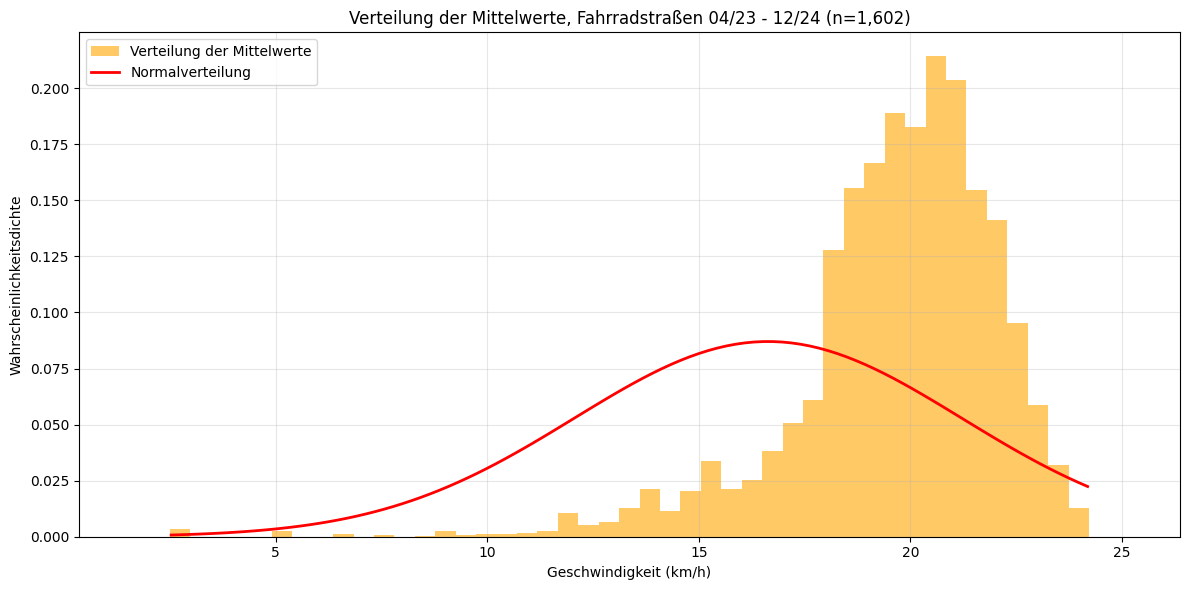

Längengewichtete Analyse abgeschlossen. Überprüfen Sie das Ausgabeverzeichnis für Ergebnisse.


In [8]:
# Visueller Test auf Normalverteilung (Fahrradstraßen)
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

# Length-Weighted CLT Test for Fahrradstraße
# Central Limit Theorem Verification with proper length-weighting throughout
# Analyzes only rows where Fahrradstrasse = 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pyarrow.parquet as pq
import gc
from tqdm.notebook import tqdm

# Configuration - modify to match your setup
PARQUET_FILE = "data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet"
OUTPUT_DIR = "analysis_results/CLT_test_FS"
COLUMN_HIST = '2304-2412_speeds'  # Column for speed histogram data
COLUMN_LENGTH = 'length_m'  # Column for length in meters
FILTER_COLUMN = 'Fahrradstrasse'  # Column to filter on

# Make sure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def log(message):
    """Print a timestamped log message"""
    print(message)

def force_gc():
    """Force garbage collection"""
    gc.collect()

def parse_histogram(hist_str):
    """Parse histogram string to numpy array"""
    try:
        if isinstance(hist_str, str):
            hist_str = hist_str.strip('[]')
            # Fast NumPy parsing
            try:
                values = np.fromstring(hist_str, sep=',')
                return values
            except:
                # Fallback to manual parsing if NumPy method fails
                values = [float(x) for x in hist_str.split(',')]
                return np.array(values)
        else:
            return np.zeros(32)  # Return zeros for missing histograms
    except Exception as e:
        log(f"Error parsing histogram: {e}")
        return np.zeros(32)

def calculate_weighted_mean(histogram):
    """Calculate weighted mean from a histogram"""
    speed_bins = np.arange(32)  # 0-31 km/h
    total_count = np.sum(histogram)
    
    if total_count > 0:
        mean_speed = np.sum(speed_bins * histogram) / total_count
        return mean_speed
    return np.nan

def verify_central_limit_theorem():
    """Verify the central limit theorem for OSM speed data filtering for Fahrradstrasse = 1 with proper length-weighting"""
    log(f"Analyzing parquet file: {PARQUET_FILE}")
    
    # Verify the parquet file exists
    if not os.path.exists(PARQUET_FILE):
        log(f"Error: File {PARQUET_FILE} not found")
        return None, None, None, None
    
    # Get file info to understand what we're working with
    parquet_file = pq.ParquetFile(PARQUET_FILE)
    num_row_groups = parquet_file.metadata.num_row_groups
    total_rows = parquet_file.metadata.num_rows
    log(f"Parquet file has {num_row_groups} row groups and approximately {total_rows:,} rows")
    
    # Define the specific columns we need, including the filter column
    columns = [COLUMN_HIST, COLUMN_LENGTH, FILTER_COLUMN]
    
    # Initialize storage for results
    segment_means = []
    segment_weights = []
    total_rows_processed = 0
    filtered_rows = 0
    
    # Process each row group with efficient chunking
    log(f"Processing {num_row_groups} row groups, filtering for {FILTER_COLUMN} = 1")
    
    # Define chunk size for efficient processing within each row group
    CHUNK_SIZE = 50000
    
    for rg in tqdm(range(num_row_groups), desc="Processing row groups"):
        try:
            # Get the row group size to determine number of chunks needed
            row_group_metadata = parquet_file.metadata.row_group(rg)
            row_group_size = row_group_metadata.num_rows
            num_chunks = (row_group_size + CHUNK_SIZE - 1) // CHUNK_SIZE  # Ceiling division
            
            log(f"Row group {rg}: {row_group_size:,} rows, processing in {num_chunks} chunks")
            
            # Read the entire row group
            table = parquet_file.read_row_group(rg, columns=columns)
            
            # Process each chunk of the row group
            for chunk_idx in tqdm(range(num_chunks), desc=f"Chunks in row group {rg}", leave=False):
                # Calculate offsets
                offset = chunk_idx * CHUNK_SIZE
                length = min(CHUNK_SIZE, row_group_size - offset)
                
                # Extract just this chunk from the row group
                chunk_table = table.slice(offset, length)
                df_chunk = chunk_table.to_pandas()
                
                # Filter rows where Fahrradstrasse = 1
                df_chunk = df_chunk[df_chunk[FILTER_COLUMN] == 1]
                filtered_rows += len(df_chunk)
                
                # Filter out NaN values
                df_chunk = df_chunk.dropna(subset=[COLUMN_HIST, COLUMN_LENGTH])
                
                # Process each row in this chunk
                for _, row in df_chunk.iterrows():
                    hist = parse_histogram(row[COLUMN_HIST])
                    if len(hist) > 0 and np.sum(hist) > 0:
                        mean = calculate_weighted_mean(hist)
                        if not np.isnan(mean):
                            segment_means.append(mean)
                            segment_weights.append(row[COLUMN_LENGTH])
                
                # Update progress counter
                total_rows_processed += length
                
                # Clean up to free memory after each chunk
                del df_chunk, chunk_table
                force_gc()
            
            # Clean up the entire row group data
            del table
            force_gc()
                
        except Exception as e:
            log(f"Error processing row group {rg}: {e}")
    
    log(f"Analysis complete. Processed {total_rows_processed:,} total rows")
    log(f"Found {filtered_rows:,} rows with {FILTER_COLUMN} = 1")
    log(f"Calculated {len(segment_means):,} valid weighted means from filtered rows")
    
    # Convert to numpy arrays for analysis
    segment_means = np.array(segment_means)
    segment_weights = np.array(segment_weights)
    
    # Check if we have enough data to proceed
    if len(segment_means) < 30:
        log("Warning: Only " + str(len(segment_means)) + " data points found. This is below the typical threshold of 30 for CLT reliability.")
        log("Continuing with analysis anyway as requested.")
    
    # Calculate total weight for reporting only
    total_weight = np.sum(segment_weights)
    
    # No logging of mean values
    
    # Create figure with single histogram plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot 1: Length-weighted histogram
    bins = np.linspace(max(0, np.min(segment_means) - 1), np.max(segment_means) + 1, 50)
    
    # Use weights in the histogram
    hist_values, bin_edges, _ = ax1.hist(
        segment_means, 
        bins=bins, 
        weights=segment_weights,  # Use weights for the histogram
        density=True, 
        alpha=0.6, 
        color='orange', 
        label='Verteilung der Mittelwerte'
    )
    
    # Generate x values for normal distribution curve
    x = np.linspace(min(segment_means), max(segment_means), 100)
    
    # Calculate normal PDF with weighted mean and std
    normal_pdf = stats.norm.pdf(x, weighted_mean, weighted_std)
    
    # Plot the normal distribution curve
    ax1.plot(x, normal_pdf, 'r-', linewidth=2, label='Normalverteilung')
    
    # No normal distribution overlay
    
    ax1.set_title(f'Verteilung der Mittelwerte, Fahrradstraßen 04/23 - 12/24 (n={len(segment_means):,})')
    ax1.set_xlabel('Geschwindigkeit (km/h)')
    ax1.set_ylabel('Wahrscheinlichkeitsdichte')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # No need to remove QQ Plot as it's not created
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(OUTPUT_DIR, 'laengengewichtete_geschwindigkeitsverteilung_fahrradstrasse.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # No calculation of weighted skewness and kurtosis
    
    # No normality tests
    
    # Create and save summary to a text file
    summary = f"""Längengewichtete Datenanalyse Zusammenfassung (Gefilterte Daten)
=========================================
Angewandter Filter: {FILTER_COLUMN} = 1
Verarbeitete Zeilen insgesamt: {total_rows_processed:,}
Zeilen mit Filterübereinstimmung: {filtered_rows:,}
Gültige Segmente: {len(segment_means):,}
Gesamtlänge Fahrradstraße: {total_weight/1000:.2f} km

Hinweis: Diese Analyse basiert auf Geschwindigkeitsverteilungen von Fahrradstraßen, wobei jedes Segment entsprechend seiner Länge gewichtet wurde.
    """
    
    with open(os.path.join(OUTPUT_DIR, 'laengengewichtete_analyse_fahrradstrasse_zusammenfassung.txt'), 'w') as f:
        f.write(summary)
    
    log("Längengewichtete Analyse abgeschlossen. Überprüfen Sie das Ausgabeverzeichnis für Ergebnisse.")
    return segment_means, segment_weights

# Run the analysis
segment_means, segment_weights = verify_central_limit_theorem()